# Assigning HF & EF demand to clusters
<br>

**Conceptualization, Methodology & Code:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br> **Supervision, Review and Advisory support:** [Benjamin P. Stewart](https://github.com/bpstewar), [Ashish Shrestha](mailto:ashrestha1@worldbank.org), [Rhonda Lenai Jordan](mailto:rjordan@worldbank.org)<br> **Funding:** The World Bank


# Step 1. Setting up python env & Importing datasets

## Import necessary modules

As part of any modeling exercise in jupyter, the first step requires that the necessary python modules are imported. You may refer to the [requirements.txt]() to check dependencies for this notebook.

In [1]:
# Import python modules
import geopandas as gpd
import pandas as pd
import pyproj
import numpy as np

from functools import reduce
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import nearest_points

#import datapane as dp
# !datapane login --token="yourpersonaltoken"

import folium
from folium.features import GeoJsonTooltip
import branca.colormap as cm
import os
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline

## Importing datasets

Here we import the datasets that we are going to work with. These include the following three:

**1. Administrative boundaries (vector polygon):** This defines the boundary box over our area of interest. In this example we use the administrative boundaries of Somaliland. You may retrieve this from [GADM](https://gadm.org/) 

**2. Locations of health facilities (vector points)**: In this case we use a spatial database of health facilities that has been prepared by collecting and merging different available sources for Somaliland.

**3. Population clusters (vector polygons)**: This refers to a vectorized version of built-up areas as described and developed by [Korkovelos et al.](https://www.mdpi.com/1996-1073/12/7/1395). In this exercise we use a custom output created for Somaliland.

<br>

> **Note 1**. For the purposes of this exercise both (2) and (3) have been clipped based on (1) before being imported in the notebook. You may used [geopandas](https://geopandas.org/reference/geopandas.clip.html) or [Qgis](https://docs.qgis.org/2.8/en/docs/user_manual/processing_algs/gdalogr/ogr_geoprocessing/clipvectorsbypolygon.html) to do this.

> **Note 2**. All datasets are in WGS84 coordinate systems prior importing. Please make sure that this is the case and correct if otherwise.

### Importing admin boundary as geodataframe

In [2]:
# Define path and name of the file
admin_path = r"sample_input"
admin_name = "Somaliland_adm0.gpkg"

In [3]:
# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

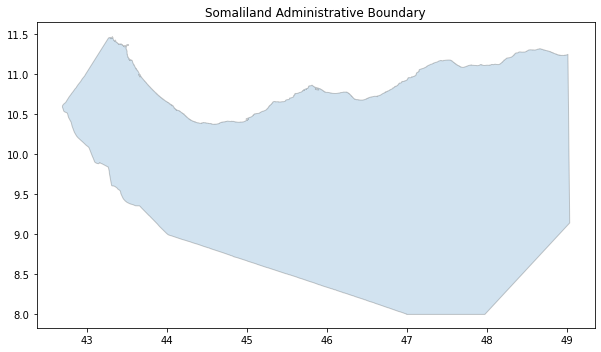

In [4]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
ax.set_aspect('equal', 'box')
txt = ax.set_title('Somaliland Administrative Boundary'.format(""))

### Importing health facilities 

**Note** that for the code below to work properly this should be a "Point" layer; in case the geometry is characterized as "Multipoint" you should convert it into a "Point" to proceed. You may use [Qgis](http://www.saga-gis.org/saga_tool_doc/3.0.0/shapes_points_15.html) to do this.

In [5]:
# Define path and name of the file
health_path = r"sample_input"
health_name = "HF_WHO_SARA_GoSL_geotagged.gpkg"

In [6]:
# Create a new geo-dataframe
health_gdf = gpd.read_file(health_path + "\\" + health_name)

In [7]:
health_gdf.head(3)

,UID,Lat,Lon,Region,District,Location,Facility Name,Type,Maternal_Child_Care,TB_treatment,No_ppl_served,Coord_status,Ownership,Priority for connection,Source,geometry
0,1,9.60228,43.336445,Waqoyi_Galbeed,Gabiley,Wajaale town,Wajaale hf,Health_Center,None,None,NaN,identified,MOHD,"Medical equipment Sterilization, Vaccine refri...",GoSL_geotagged,POINT (43.33644 9.60228)
1,2,9.72068,43.422370,Waqoyi_Galbeed,None,Xunshaley town,Xunshaley hf,Health_Center,None,None,NaN,identified,MOHD,"Medical equipment Sterilization, Vaccine refri...",GoSL_geotagged,POINT (43.42237 9.72068)
2,3,9.65792,43.425260,Waqoyi_Galbeed,Gabiley,Idhanka town,Idhanka,Health_Center,None,None,NaN,identified,MOHD,"Medical equipment Sterilization, Vaccine refri...",GoSL_geotagged,POINT (43.42526 9.65792)


In [8]:
# Adding an index column
health_gdf['index'] = range(1, len(health_gdf)+1)

#### ... and visualizing 

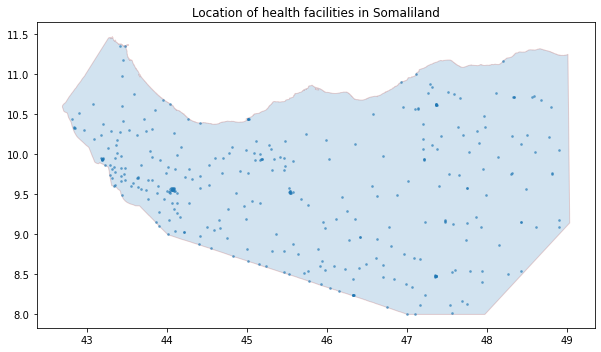

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
health_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Location of health facilities in Somaliland'.format(""))

### Importing education facilities 

**Note** that for the code below to work properly this should be a "Point" layer; in case the geometry is characterized as "Multipoint" you should convert it into a "Point" to proceed. You may use [Qgis](http://www.saga-gis.org/saga_tool_doc/3.0.0/shapes_points_15.html) to do this.

In [10]:
# Define path and name of the file
edu_path = r"sample_input"
edu_name = "EF_UNICEF_GoSL_geotagged.gpkg"

In [11]:
# Create a new geo-dataframe
edu_gdf = gpd.read_file(edu_path + "\\" + edu_name)

In [12]:
edu_gdf.head(3)

,Lon,Lat,Region,District,Location,EF_name,Type,Enrolment,Coord_status,Source,geometry
0,46.325828,8.236913,None,None,None,None,Primary,NaN,provided,UNICEF,POINT (46.32583 8.23691)
1,46.325828,8.236913,None,None,None,None,Primary,NaN,provided,UNICEF,POINT (46.32583 8.23691)
2,46.325828,8.236913,None,None,None,None,Primary,NaN,provided,UNICEF,POINT (46.32583 8.23691)


In [13]:
# Adding an index column
edu_gdf['index'] = range(1, len(edu_gdf)+1)

#### ... and visualizing 

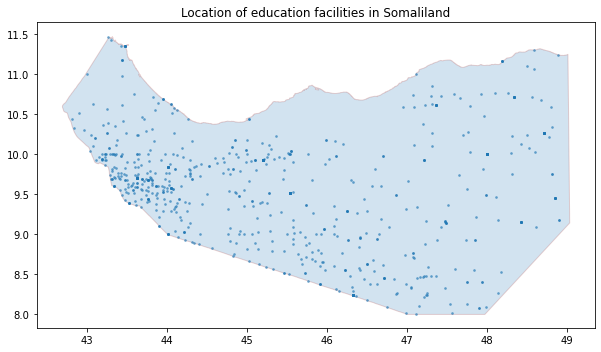

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
edu_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Location of education facilities in Somaliland'.format(""))

### Importing population clusters

In [15]:
# Define path and name of the file
clusters_path = r"sample_input"
clusters_name = "Somaliland_WBPeanutButter_clusters_clipped.gpkg"

In [16]:
clusters_gdf = gpd.read_file(clusters_path + "\\" + clusters_name)

In [17]:
clusters_gdf.head(2)

,id,Country,NightLight,Buildings,Pop,Area,ElecPop,IsUrban,geometry
0,16555.0,Somaliland,0.0,12.0,55.837082,0.034724,0.0,0,"MULTIPOLYGON (((43.53792 9.98375, 43.53958 9.9..."
1,19586.0,Somaliland,0.0,6.0,27.918543,0.017358,0.0,0,"MULTIPOLYGON (((43.48625 9.91208, 43.48792 9.9..."


#### ... and creating a new geodataframe with the centroids of each cluster

In [18]:
clusters_centroid = gpd.GeoDataFrame(clusters_gdf, geometry=clusters_gdf.centroid)

<ipython-input-18-e2fa3ffd13f4>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters_centroid = gpd.GeoDataFrame(clusters_gdf, geometry=clusters_gdf.centroid)


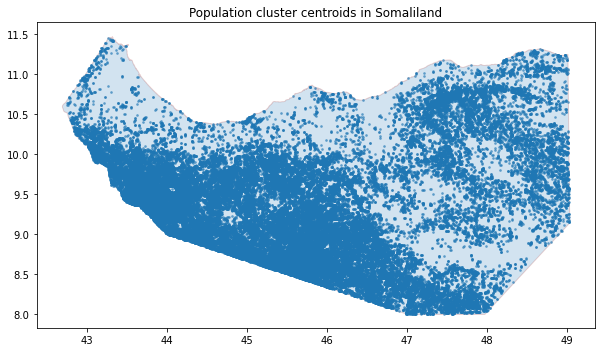

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
clusters_centroid.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Population cluster centroids in Somaliland'.format(""))

In [20]:
print ('\n\033[1mNote!\033[0m\n\nThere are {} clusters in selected administrative area, where {:.0f} people reside.\nThese are served by {} health facilities.\n'.
       format(len(clusters_centroid), clusters_centroid.Pop.sum(), len(health_gdf)))


Note!

There are 93978 clusters in selected administrative area, where 3607668 people reside.
These are served by 348 health facilities.



**Note: In case you already have a category/type specified for each Health Facility, you may proceed to step 3**

## Step 2. Characterizing HF & Predicting electricity requirements

You may select any of the above approaches to proceed.

## Health Facilities

In [21]:
HF = health_gdf

#### Plotting result of categorization

Text(0.5, 1.0, 'Categorization of Health facilities in the selected admin area')

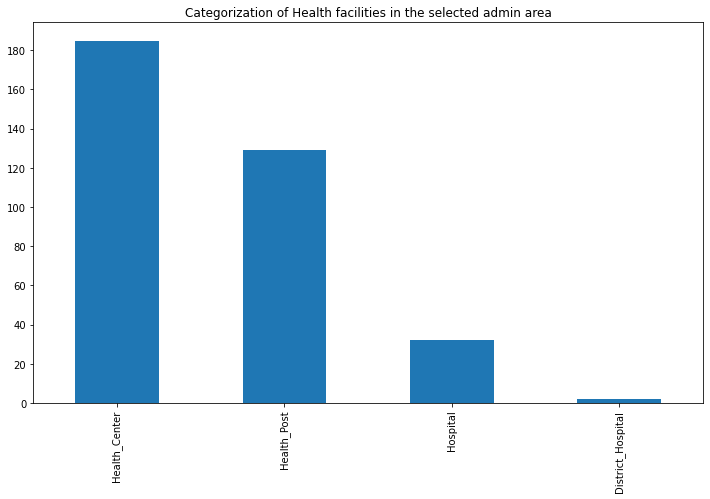

In [22]:
ax = HF['Type'].value_counts().plot(kind='bar',figsize=[12,7])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Categorization of Health facilities in the selected admin area")

## Assign electricity requirements based on Category type

Similar to classification (see above) estimating electricity requirement per health facility is not an easy task considering the lack of quantitative, ground data. In this example, we use the [HOMER Powering Health Tool](https://poweringhealth.homerenergy.com/) interface to quantify potential electricity requirement (kWh/year) per type of health facility. The modeler can select the appropriate equipment and customize electricity targets accordingly. 

In [23]:
# Rural dispensary - no inpatient - 4 emergency beds
HF.loc[(HF['Type'] == "Health_Post"), 'HF_kWh'] = 5.7*365

HF.loc[(HF['Type'] == "Health_Center"), 'HF_kWh'] = 13.9*365                           
                           
HF.loc[(HF['Type'] == "Hospital"), 'HF_kWh'] = 37*365                           

HF.loc[(HF['Type'] == "District_Hospital"), 'HF_kWh'] = 361.1*365

In [24]:
print ('\n\033[1mNote!\033[0m\n\nThe estimated electricity demand for HF in the selected area, based on the above categorization, is ~{:.1f} kWh/year \n'.
       format(HF.HF_kWh.sum()))


Note!

The estimated electricity demand for HF in the selected area, based on the above categorization, is ~1902745.0 kWh/year 



# Print location of HF with estimated demand on a map 

In [25]:
# Vizualize result on an interactive map exported as html 

#Define limits for map rendering
x_ave = HF["Lon"].mean()
y_ave = HF["Lat"].mean()

# Create the map using folium module
map_dem = folium.Map(location=[y_ave,x_ave], zoom_start=6, control_scale=True)

# Definition of a function that returns different color names based on lcoe result categorization
# Colors are in Hexa-code e.g. #RRGGBB
def colorvalue(x):
    if x <= 0.5:
        return "#ADFF2F"
    elif x >= 1 and x < 5000:
        return "#32CD32"
    elif x >= 5000 and x < 10000:
        return "#228B22"
    elif x >= 10000 and x < 15000:
        return "#008000"
    elif x >= 15000 and x < 20000:
        return "#006400"
    else:
        return "#000000" 

# Then we create a marker for each cluster; 
# We pass coordinates, lcoe value and size as attributes to appear on the rendered map
for index, row in HF.iterrows():
    el_demand = row["HF_kWh"]
    color_code = colorvalue(el_demand)
    folium.CircleMarker([row["Lat"], row["Lon"]],
                        radius=2,
                        color=color_code,
                        popup="<b>Name:</b> {}, <br> <br> <b>Type:</b> {}, <br> <br> <b>Demand:</b> {} kWh/year, <br> <br> <b>".format(row["Facility Name"], row["Type"], row["HF_kWh"]),
                        fill = True,
                        fill_opacity=0).add_to(map_dem)

# We define the limits of the legend and fix its printout format
# We use branca module to create a colormap legend and then add legend to the map
min_dem = HF["HF_kWh"].min()
max_dem = HF["HF_kWh"].max()
min_dem = float("{0:.2f}".format(min_dem))
max_dem = float("{0:.2f}".format(max_dem))
legend = cm.LinearColormap(['#ADFF2F','#32CD32','#228B22','#008000','#006400','#000000'], 
                           index=None, vmin=min_dem, vmax=max_dem)
legend.add_to(map_dem)  

expl_text = '#ADFF2F:1, #32CD32:2, #228B22:3, #008000:4, #006400:5'
iframe = folium.IFrame(expl_text, width=700, height=450)
popup = folium.Popup(iframe, max_width=3000)

Text = folium.Marker(location=[x_ave,y_ave], popup=popup,
                     icon=folium.Icon(icon_color='green'))
map_dem.add_child(Text)

# Create a new directory where the map(s) can be saved
try:
    os.makedirs('maps')
except FileExistsError:
    pass

map_dem_output = 'maps/map_{}_{}.html'.format("Health_Facilities", "Somaliland")
map_dem.save(map_dem_output)

# Finally add the link that leads to the final map output
display(Markdown('<a href="{}" target="_blank">Click here to render the map of electrification of health facilities </a>'.format(map_dem_output)))

# Publish map on datapane for easier rendering in websites
#dp.Report(dp.Plot(map_dem)).publish(name='HF_elec_demand_Somaliland', visibility='PUBLIC')

map_dem

<a href="maps/map_Health_Facilities_Somaliland.html" target="_blank">Click here to render the map of electrification of health facilities </a>

## Education Facilities

In [26]:
EF = edu_gdf

#### Plotting result of categorization

Text(0.5, 1.0, 'Categorization of Education facilities in the selected admin area')

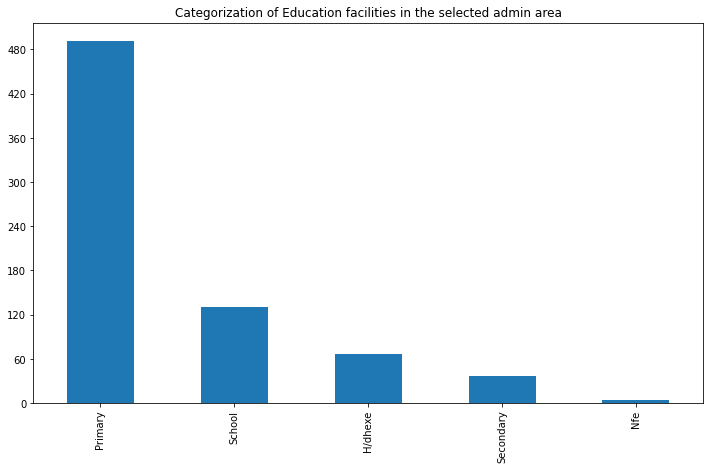

In [27]:
ax = EF['Type'].value_counts().plot(kind='bar',figsize=[12,7])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Categorization of Education facilities in the selected admin area")

## Assign electricity requirements based on Category type

Similar to classification (see above) estimating electricity requirement per health facility is not an easy task considering the lack of quantitative, ground data. In this example, we use the [HOMER Powering Health Tool](https://poweringhealth.homerenergy.com/) interface to quantify potential electricity requirement (kWh/year) per type of health facility. The modeler can select the appropriate equipment and customize electricity targets accordingly. 

In [28]:
# Schools 
EF.loc[(EF['Type'] == "Primary"), 'EF_kWh'] = 5.7*365

EF.loc[(EF['Type'] == "Secondary"), 'EF_kWh'] = 13.9*365                           
                           
EF.loc[(EF['Type'] == "School"), 'EF_kWh'] = 37*365                           

EF.loc[(EF['Type'] == "H/dhexe"), 'EF_kWh'] = 361.1*365

EF.loc[(EF['Type'] == "Nfe"), 'EF_kWh'] = 361.1*365

In [29]:
print ('\n\033[1mNote!\033[0m\n\nThe estimated electricity demand for EF in the selected area, based on the above categorization, is ~{:.1f} kWh/year \n'.
       format(EF.EF_kWh.sum()))


Note!

The estimated electricity demand for EF in the selected area, based on the above categorization, is ~12206585.5 kWh/year 



# Print location of EF with estimated demand on a map 

In [30]:
# Vizualize result on an interactive map exported as html 

#Define limits for map rendering
x_ave = EF["Lon"].mean()
y_ave = EF["Lat"].mean()

# Create the map using folium module
map_dem = folium.Map(location=[y_ave,x_ave], zoom_start=6, control_scale=True)

# Definition of a function that returns different color names based on lcoe result categorization
# Colors are in Hexa-code e.g. #RRGGBB
def colorvalue(x):
    if x <= 0.5:
        return "#ADFF2F"
    elif x >= 1 and x < 5000:
        return "#32CD32"
    elif x >= 5000 and x < 10000:
        return "#228B22"
    elif x >= 10000 and x < 15000:
        return "#008000"
    elif x >= 15000 and x < 20000:
        return "#006400"
    else:
        return "#000000" 

# Then we create a marker for each cluster; 
# We pass coordinates, lcoe value and size as attributes to appear on the rendered map
for index, row in EF.iterrows():
    el_demand = row["EF_kWh"]
    color_code = colorvalue(el_demand)
    folium.CircleMarker([row["Lat"], row["Lon"]],
                        radius=2,
                        color=color_code,
                        popup="<b>Name:</b> {}, <br> <br> <b>Type:</b> {}, <br> <br> <b>Demand:</b> {} kWh/year, <br> <br> <b>".format(row["EF_name"], row["Type"], row["EF_kWh"]),
                        fill = True,
                        fill_opacity=0).add_to(map_dem)

# We define the limits of the legend and fix its printout format
# We use branca module to create a colormap legend and then add legend to the map
min_dem = EF["EF_kWh"].min()
max_dem = EF["EF_kWh"].max()
min_dem = float("{0:.2f}".format(min_dem))
max_dem = float("{0:.2f}".format(max_dem))
legend = cm.LinearColormap(['#ADFF2F','#32CD32','#228B22','#008000','#006400','#000000'], 
                           index=None, vmin=min_dem, vmax=max_dem)
legend.add_to(map_dem)  

expl_text = '#ADFF2F:1, #32CD32:2, #228B22:3, #008000:4, #006400:5'
iframe = folium.IFrame(expl_text, width=700, height=450)
popup = folium.Popup(iframe, max_width=3000)

Text = folium.Marker(location=[x_ave,y_ave], popup=popup,
                     icon=folium.Icon(icon_color='green'))
map_dem.add_child(Text)

# Create a new directory where the map(s) can be saved
try:
    os.makedirs('maps')
except FileExistsError:
    pass

map_dem_output = 'maps/map_{}_{}.html'.format("Education_Facilities", "Somaliland")
map_dem.save(map_dem_output)

# Finally add the link that leads to the final map output
display(Markdown('<a href="{}" target="_blank">Click here to render the map of electrification of health facilities </a>'.format(map_dem_output)))

# Publish map on datapane for easier rendering in websites
#dp.Report(dp.Plot(map_dem)).publish(name='EF_elec_demand_Somaliland', visibility='PUBLIC')

map_dem

<a href="maps/map_Education_Facilities_Somaliland.html" target="_blank">Click here to render the map of electrification of health facilities </a>

# Step 3. Assign HF and EF target demand back to pop clusters

Electricity demand of each Health & Education Facility is assigned to the closest cluster.

(NNA code retrieved from [shakasom](https://github.com/shakasom/NearestNeighbour-Analysis))

In [31]:
# Simple function getting the nearest hub for a given set of points
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [32]:
#Function to change the order of columns in the dataframe 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

## Health Facilities

#### Find nearest cluster

In [33]:
HF["id"] = HF.apply(calculate_nearest, destination=clusters_centroid, val="id", axis=1)

#### Group by cluster id & delete other HF columns

In [63]:
HF_grouped_by_cluster = HF.groupby(["id"]).sum().reset_index().drop(["UID", "Lat", "Lon", "No_ppl_served", "index"], axis=1)

#### Merge result to initial clusters

In [66]:
clusters_gdf = gpd.read_file(clusters_path + "\\" + clusters_name)

In [70]:
final_clusters_HF_kWh = HF_grouped_by_cluster.merge(clusters_gdf, how="outer", on='id')
final_clusters_HF_kWh["HF_kWh"] = final_clusters_HF_kWh["HF_kWh"].fillna(0)

## Education Facilities

#### Find nearest cluster

In [75]:
EF["id"] = EF.apply(calculate_nearest, destination=clusters_centroid, val="id", axis=1)

In [76]:
EF.columns

Index(['Lon', 'Lat', 'Region', 'District', 'Location', 'EF_name', 'Type',
       'Enrolment', 'Coord_status', 'Source', 'geometry', 'index', 'EF_kWh',
       'id'],
      dtype='object')

#### Group by cluster id & delete other EF columns

In [91]:
EF_grouped_by_cluster = EF.groupby(["id"]).sum().reset_index().drop(["Lon","Lat", 'Enrolment','index'], axis=1)

#### Merge result to initial clusters

In [94]:
final_clusters_HF_EF_kWh = EF_grouped_by_cluster.merge(final_clusters_HF_kWh, how="outer", on='id')
final_clusters_HF_EF_kWh["EF_kWh"] = final_clusters_HF_EF_kWh["EF_kWh"].fillna(0)

#### Tidy up output

In [96]:
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'id', 0)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'Country', 1)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'Pop', 2)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'Area', 3)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'IsUrban', 4)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'NightLight', 5)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'ElecPop', 6)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'HF_kWh', 7)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'EF_kWh', 8)
final_clusters_HF_EF_kWh = change_column_order(final_clusters_HF_EF_kWh, 'geometry', 9)

------------------------------------------------------------------------------------

# Step 4. Map results and export pop cluster dataset 

In [97]:
final_clusters_HF_EF_kWh_gdf = gpd.GeoDataFrame(final_clusters_HF_EF_kWh, geometry='geometry', crs={'init': 'epsg:4326'})

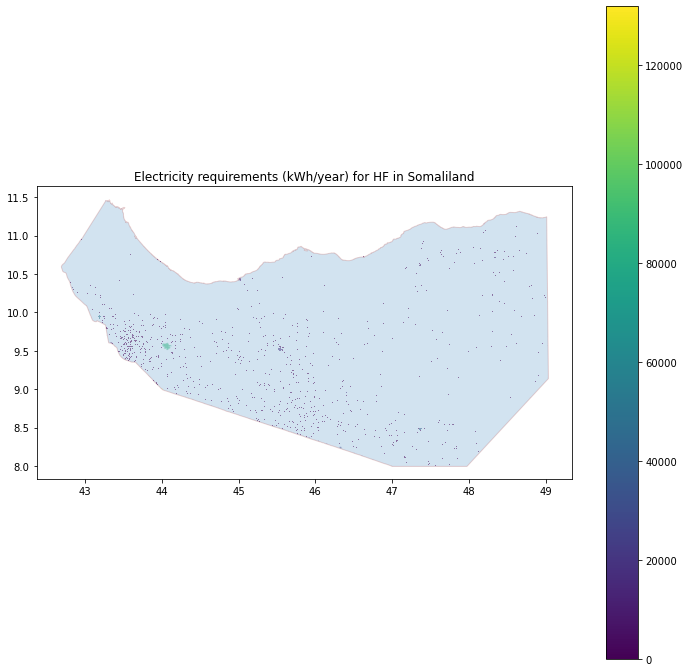

In [98]:
# Create the axis first
fig, ax = plt.subplots(figsize=(12, 12))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

final_clusters_HF_EF_kWh_gdf.sort_values('HF_kWh', ascending=True).plot(ax=ax, column='HF_kWh',
                                                                        legend=True, markersize=3, cmap="viridis",
                                                                        figsize=(12, 12), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity requirements (kWh/year) for HF in Somaliland'.format(""))

# Save plot as figure 
#plt.savefig(os.path.join(sample_output, 'xxxxx.png'), bbox_inches='tight')
#logging.getLogger('matplotlib.font_manager').disabled = True

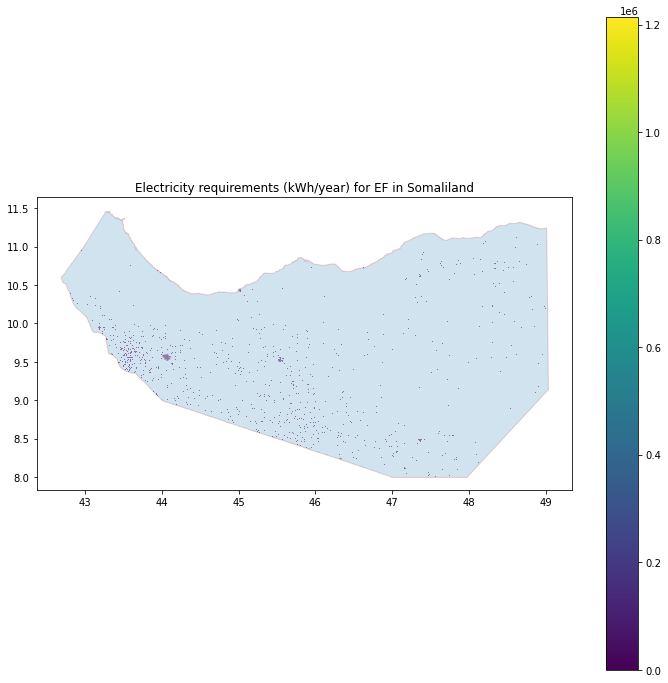

In [99]:
# Create the axis first
fig, ax = plt.subplots(figsize=(12, 12))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

final_clusters_HF_EF_kWh_gdf.sort_values('EF_kWh', ascending=True).plot(ax=ax, column='EF_kWh',
                                                                        legend=True, markersize=3, cmap="viridis",
                                                                        figsize=(12, 12), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity requirements (kWh/year) for EF in Somaliland'.format(""))

# Save plot as figure 
#plt.savefig(os.path.join(sample_output, 'xxxxx.png'), bbox_inches='tight')
#logging.getLogger('matplotlib.font_manager').disabled = True

#### Export layer to geopackage

In [100]:
output_path = r"sample_output"
out_name = "Somaliland_WBPeanutButter_clusters_clipped_HF_EF_kWh.gpkg"
final_clusters_HF_EF_kWh_gdf.to_file(os.path.join(output_path,"{c}".format(c=out_name)), driver="GPKG")